In [2]:
import os
import pandas as pd

import imageio
import nibabel as nib
import scipy.ndimage as ndi
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import math
import numpy as np
import cv2
import SimpleITK as sitk
from skimage import io
from skimage.measure import find_contours

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from sources.utils import *

mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
def has_tumor(mask):
    '''
    mask should be a binary 2D array (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    Return True if all pixel values of mask is equal to 0 (mask do not contain tumor)
    '''
    return sum(mask.ravel()) > 0

def get_index_tumor_slice(images, masks):
  '''
    Return index of images/masks where tumor is visible
    images and masks are 2D or 3D array with same dimensions
    masks should contain atleat one slice with tumor
  '''
  tumor_idx = []
  if len(masks.shape) == 3:
    for i in range(0, masks.shape[2]):
      # detect binary mask with no tumor (all pixel equal to 0)
      if has_tumor(masks[:,:,i]):
        tumor_idx.append(i)
  elif len(masks.shape) == 2:
      # detect binary mask with no tumor (all pixel equal to 0)
    if has_tumor(masks[:,:,i]):
      tumor_idx.append(i)

  if not tumor_idx:
    raise ValueError("There must be at least one slice with tumor")
  else:
    return tumor_idx 

In [3]:
base_url = 'Task10_Colon/'

path_to_images = base_url + 'imagesTr/'
path_to_mask = base_url + 'labelsTr/'
filenames = os.listdir(path_to_images)
filenames = [i for i in os.listdir(path_to_images) if not i.startswith(".")]

In [4]:
file = []
nbslice = []
nbslice_tumor = []

for filename in filenames:
    image_3d = nib.load(os.path.join(path_to_images, filename)).get_fdata()
    mask_3d = nib.load(os.path.join(path_to_mask, filename)).get_fdata()

    # check if size mask and image are equal
    if image_3d.shape[0] != mask_3d.shape[0] or image_3d.shape[1] != mask_3d.shape[1]:
        print("size different between mask and image")
       # check if same number of slice in mask and image
    elif image_3d.shape[2] != image_3d.shape[2]:
        print("slice number different between mask and image")
    else:
        index_tumor = get_index_tumor_slice(image_3d, mask_3d)
        slice_image = image_3d.shape[2] -1
        slice_image_with_tumors = len(index_tumor)

        file.append(filename)
        nbslice.append(slice_image - slice_image_with_tumors)
        nbslice_tumor.append(slice_image_with_tumors)

        print("{} : {}/{} : {} total slices, {} slices with tumors)".format(filename, image_3d.shape[0],image_3d.shape[1],slice_image, slice_image_with_tumors))        
        df = pd.DataFrame({'name': pd.Series(file), 'nbrslide': pd.Series(nbslice),'nbslice_tumor':pd.Series(nbslice_tumor)})

#df.to_csv("CCR_slides.csv", index=False)


colon_106.nii.gz : 512/512 : 92 total slices, 5 slices with tumors)
colon_088.nii.gz : 512/512 : 94 total slices, 7 slices with tumors)
colon_161.nii.gz : 512/512 : 94 total slices, 10 slices with tumors)
colon_050.nii.gz : 512/512 : 141 total slices, 35 slices with tumors)


In [3]:
df = pd.read_csv("CCR_slides.csv")
df.head()

,name,nbrslide,nbslice_tumor
0,colon_001.nii.gz,56,3
1,colon_005.nii.gz,85,12
2,colon_007.nii.gz,66,7
3,colon_009.nii.gz,79,10
4,colon_011.nii.gz,83,6


In [4]:
formatted_df = pd.melt(df, id_vars=["name"], value_vars=["nbrslide","nbslice_tumor"], var_name="slice_type")
formatted_df = formatted_df.sort_values(by=["name"])
formatted_df.head()

,name,slice_type,value
0,colon_001.nii.gz,nbrslide,56
126,colon_001.nii.gz,nbslice_tumor,3
1,colon_005.nii.gz,nbrslide,85
127,colon_005.nii.gz,nbslice_tumor,12
214,colon_006.nii.gz,nbslice_tumor,4


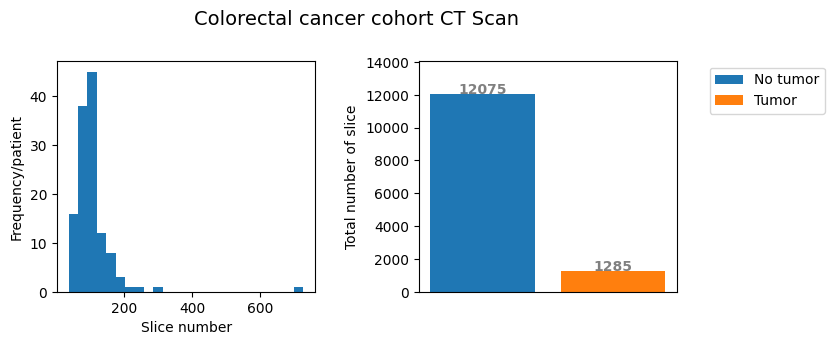

In [77]:
import seaborn as sns

data = formatted_df.groupby("slice_type")["value"].sum()
labels = data.keys()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(df['nbrslide'] + df['nbslice_tumor'], bins=25)
ax[0].set_ylabel('Frequency/patient')
ax[0].set_xlabel('Slice number')

ax[1].bar(labels[0], data[0], label='No tumor')
ax[1].bar(labels[1], data[1], label='Tumor')
ax[1].set_ylabel('Total number of slice')
ax[1].axes.get_xaxis().set_ticks([])
ax[1].set_ylim([0, data[0] + 2000])
ax[1].legend(loc='upper right', bbox_to_anchor=(1.6, 1))

#ax[1].text(1, 0.9, str(data[1]), fontsize=10, fontweight='bold', color='grey')
#ax[1].text(0, 0.9, str(data[0]), fontsize=10, fontweight='bold', color='grey')

for i in ax[1].patches:
    height = i.get_height()
    #ax[1].text((i.get_x() + i.get_width()/5), i.get_height(), str(round((i.get_height()), 2)),
    #        fontsize=10, fontweight='bold', color='grey')
    ax[1].text((i.get_x() + i.get_width()/2.0),height, str(i.get_height()), ha='center',
            fontsize=10, fontweight='bold', color='grey')

    
    
 
    
    
fig.suptitle("Colorectal cancer cohort CT Scan", fontsize=14, y=1.05)

plt.subplots_adjust(wspace=0.4)
plt.show()

In [61]:
for i in ax[1].patches:
    print(i)
    ax[1].text(i.get_x(), i.get_height(), str(round((i.get_width()), 2)),
            fontsize=10, fontweight='bold', color='grey')
    print(i.get_width())
    print(i.get_x())

Rectangle(xy=(-0.4, 0), width=0.8, height=12075, angle=0)
0.8
-0.4
Rectangle(xy=(0.6, 0), width=0.8, height=1285, angle=0)
0.8
0.6


In [8]:
def image_picker(min_slice, max_slice):
    '''
    return an array containing (max 18) equidistant index number between min_slice and max_slice
    min_slice and max_slice are interger (min_slice cannot be >= max_slice)
    '''
    row = 3
    col = 6 
    picker = math.ceil((max_slice - min_slice)/(row*col))
    index_list = []
    index = min_slice
    
    for i in range(row*col):
      if index < max_slice:
        index_list.append(index)
        index += picker
      else:
        index_list.append(max_slice)
        break
    return index_list

In [9]:
def plot_bbox_image(images, masks, crop_margin=0, zooming=False):
  '''
    Plot equidistant slices with bounding boxe containing the tumor 
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D array with same dimensions
  '''

  if len(masks.shape) != 2:
    raise ValueError("only accept one array of 2D dimension")

  xmin, ymin, xmax, ymax = get_bounding_box(masks, crop_margin)

  plt.imshow(images, cmap='gray')
  plt.plot([xmin, xmax], [ymin, ymin], color='red')
  plt.plot([xmax, xmax], [ymin, ymax], color='red')
  plt.plot([xmin, xmin], [ymin, ymax], color='red')
  plt.plot([xmin, xmax], [ymax, ymax], color='red')

  if zooming:
    plt.plot([xmax, 511], [ymax, 511], color='red')
    plt.plot([xmax, 511], [ymin, 0], color='red')

In [10]:
def PlotImage(images, masks=None, show_tumor_only = False, dislay_mode=None):
  '''
    Plot equidistant slices along mask and corresponding images along col/row grid 
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D or 3D array with same dimensions
    if masks = None, Only images are displayed
    if show_tumor_only = True: Only images containing tumor and/or corresponding masks are displayed
    
    if dislay_mode = 'mask' : Display tumor mask with corresponding images
    if dislay_mode = 'frame' : Display bounding box with corresponding images
    if dislay_mode = 'contour' : Display tumor contour with corresponding images
  '''
  row = 3
  col = 6  
  images = np.rot90(images, axes=(0, 1))

  if show_tumor_only:
    images_idx = get_index_tumor_slice(images, masks)
    slices_picker = image_picker(min_slice = images_idx[0], max_slice=images_idx[-1])
  else:
    slices_picker = image_picker(min_slice = 0, max_slice=images.shape[2]-1)

  if masks is not None:
    masks = np.rot90(masks, axes=(0, 1))
    
  plt.figure(figsize=(16, 8))
  for i, idx in enumerate(slices_picker):
    plt.subplot(row, col, i+1)
    plt.imshow(images[:,:,idx], cmap='gray')

    if masks is not None:
      if dislay_mode == 'mask':
        tumor = np.ma.masked_where(masks[:,:,idx] == False, masks[:,:,idx])
        plt.imshow(tumor, cmap='Set1')
        
      if dislay_mode == 'frame':
        plot_bbox_image(images[:,:,idx], masks[:,:,idx], crop_margin=0, zooming=False)
        
      if dislay_mode == 'contour':
        contours = find_contours(masks[:,:,idx],0)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    plt.title(str(idx+1))
    plt.axis('off')
  plt.subplots_adjust(wspace=0.05, hspace=0.2)
  plt.show()

In [11]:
filename = "colon_050.nii.gz"

image_3d = nib.load(os.path.join(path_to_images, filename)).get_fdata()
mask_3d = nib.load(os.path.join(path_to_mask, filename)).get_fdata()

print(mask_3d.shape)

(512, 512, 142)


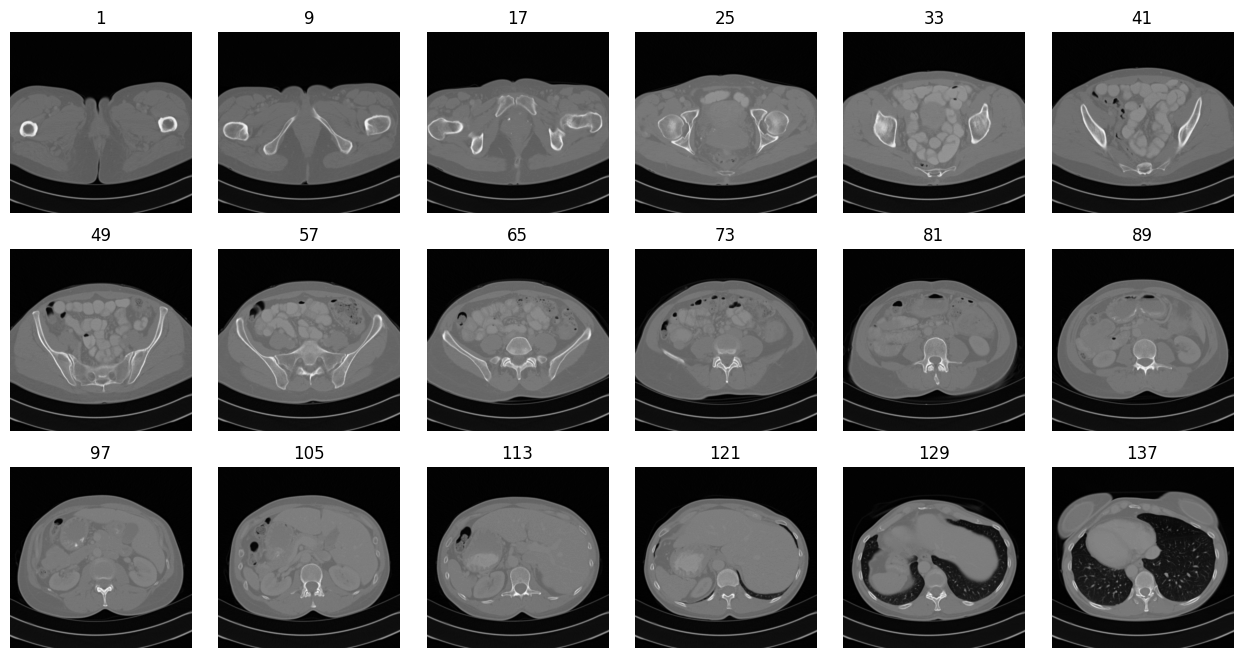

In [12]:
PlotImage(images = image_3d)

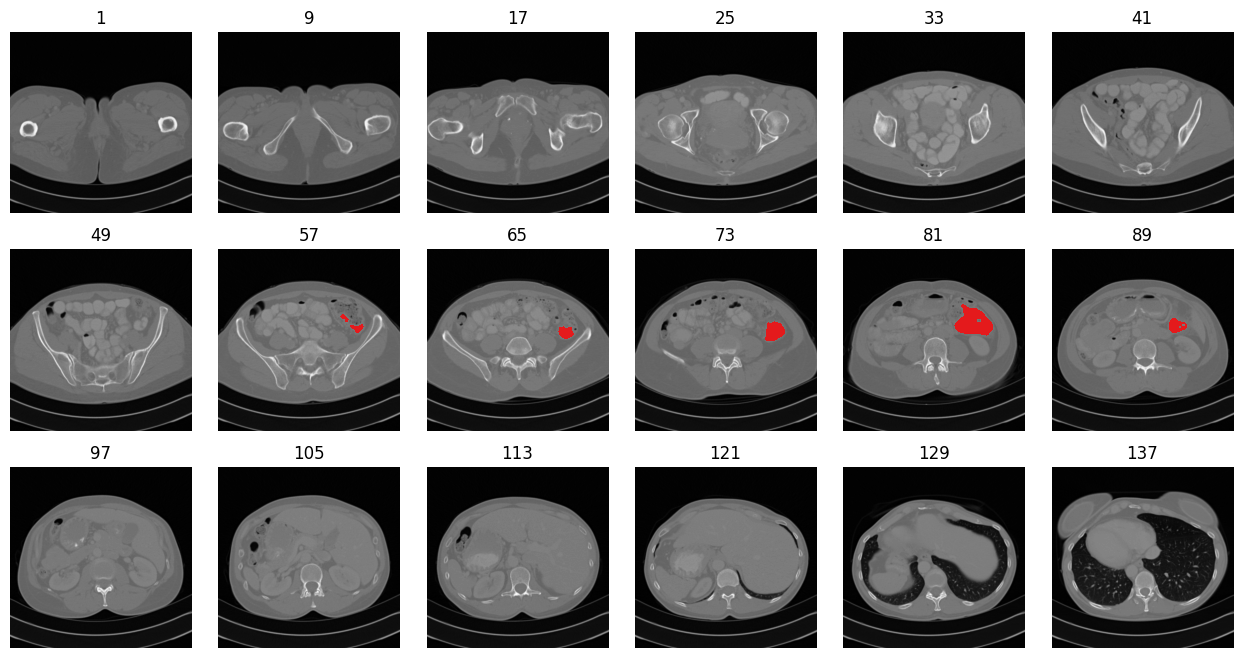

In [21]:
PlotImage(images = image_3d, masks = mask_3d, dislay_mode='mask')

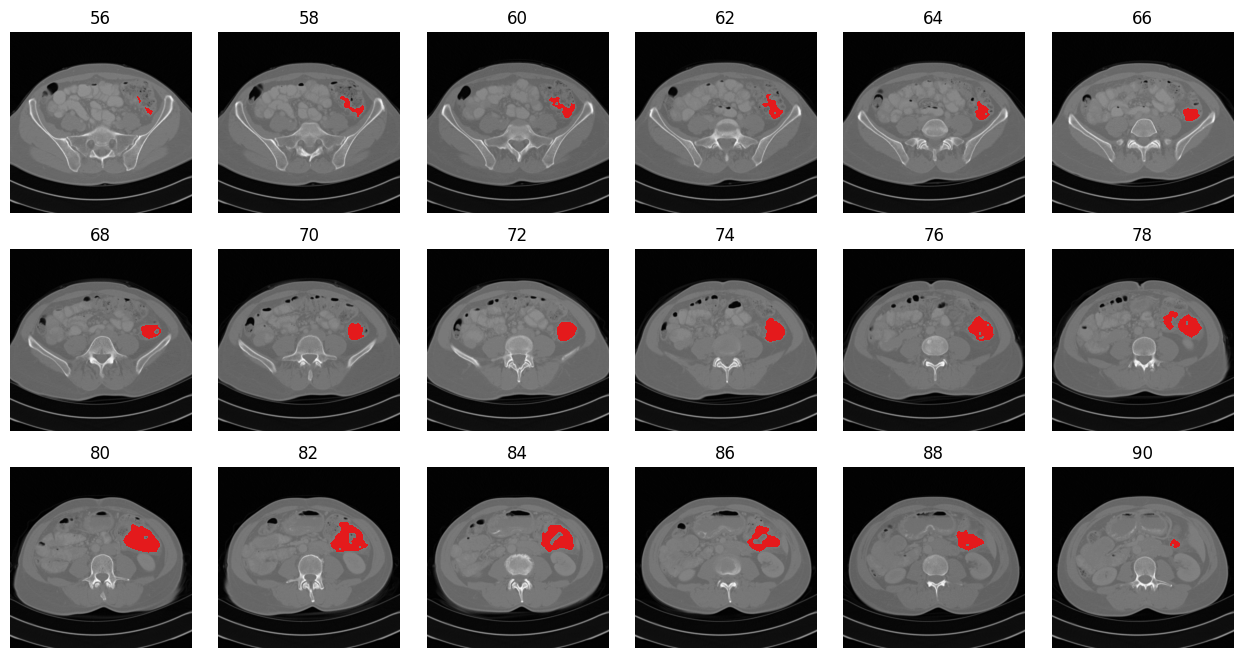

In [14]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='mask')

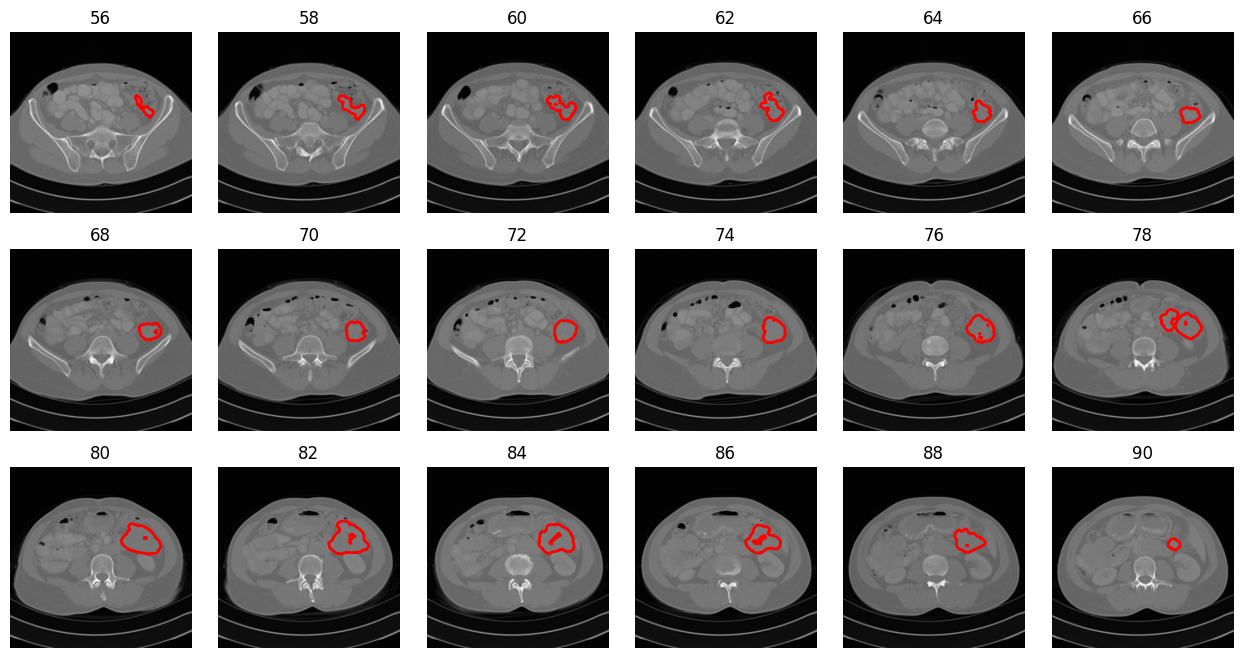

In [15]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='contour')

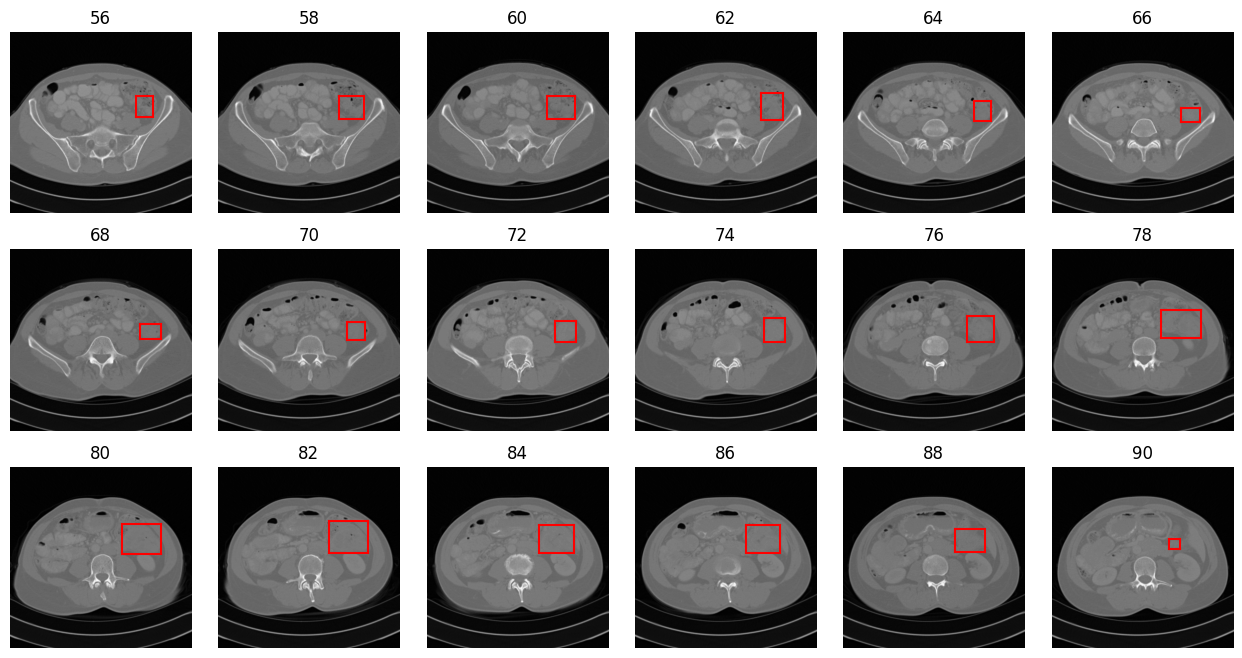

In [16]:
PlotImage(images = image_3d, masks = mask_3d, show_tumor_only = True, dislay_mode='frame')

In [18]:
def plot_tumor(images, masks, idx, save=False):
  '''
    masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
    images and masks are 2D or 3D array with same dimension
    masks should contain at leat one slice with tumor
    idx : images index along slice number (must be between min and max of tumor containing images dimension)
    if save = True, save figure in current repository
  '''
  idx -= 1

  image = np.rot90(images[:,:,idx], axes=(0, 1))
  mask = np.rot90(masks[:,:,idx], axes=(0, 1))

  fig, ax = plt.subplots(1, 3, figsize=(6, 2))

  # show image
  ax[0].imshow(image, cmap='gray')
  xmin, ymin, xmax, ymax = get_bounding_box(mask, crop_margin=10)
  ax[0].plot([xmin, xmax], [ymin, ymin], color='red')
  ax[0].plot([xmax, xmax], [ymin, ymax], color='red')
  ax[0].plot([xmin, xmin], [ymin, ymax], color='red')
  ax[0].plot([xmin, xmax], [ymax, ymax], color='red')
  ax[0].plot([xmax, 511], [ymax, 511], color='red')
  ax[0].plot([xmax, 511], [ymin, 0], color='red')

  # show image cropped around the tumor
  bbox = get_bounding_box(mask)
  croped_image = crop_to_bbox(image, bbox, crop_margin=10)
  croped_image = cv2.resize(croped_image, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_masks = crop_to_bbox(mask, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  ax[1].imshow(croped_image, cmap='gray')

  # show only the tumor
  croped_masks = crop_to_bbox(mask, bbox, crop_margin=10)
  croped_masks = cv2.resize(croped_masks, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
  croped_tumor = np.ma.masked_where(croped_masks == False, croped_image)
  croped_tumor_background = np.ma.masked_where(croped_masks == True, np.zeros((512, 512)))
  ax[2].imshow(croped_tumor, cmap='gray')
  ax[2].imshow(croped_tumor_background, cmap='gray')

  # lighten ticks and labels
  for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_color('red')
    ax[2].spines[axis].set_color('red')

    ax[1].spines[axis].set_linewidth(1)
    ax[2].spines[axis].set_linewidth(1)

    ax[1].axes.get_yaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[2].axes.get_yaxis().set_visible(False)
    ax[2].axes.get_xaxis().set_visible(False)  
    
  plt.subplots_adjust(wspace=0.02)
  fig.suptitle("Slice {}/{}".format(idx,images.shape[2]-1), fontsize=14, y = 1.05)
  plt.show()

  if True:
    fig.savefig('comparison.pdf', dpi=200) 


In [19]:
def biggest_tumor(images, masks):
  '''
  return images/masks index correspond to the biggest tumor
  masks is binary (0 : pixel do not contained tumor , 1 : pixel containing tumor)
  images and masks are 3D array with same dimension
  masks should contain at leat one slice with tumor
  '''
  mask_size = {}

  for idx in range(0, masks.shape[2]):
    if has_tumor(masks[:,:,idx]):
      mask_size[idx+1] = sum(masks[:,:,idx].ravel())
  return max(mask_size, key=mask_size.get)


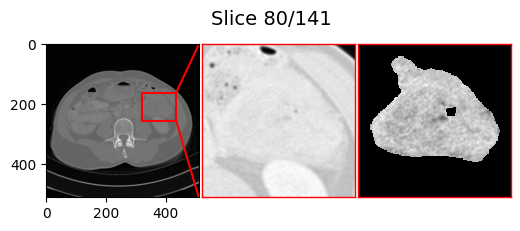

In [20]:
index_biggest_tumor = biggest_tumor(image_3d, mask_3d)
plot_tumor(image_3d, mask_3d, index_biggest_tumor)